# Predicting Hits at Wrigley Field (2022)

## Project Description

### Overview

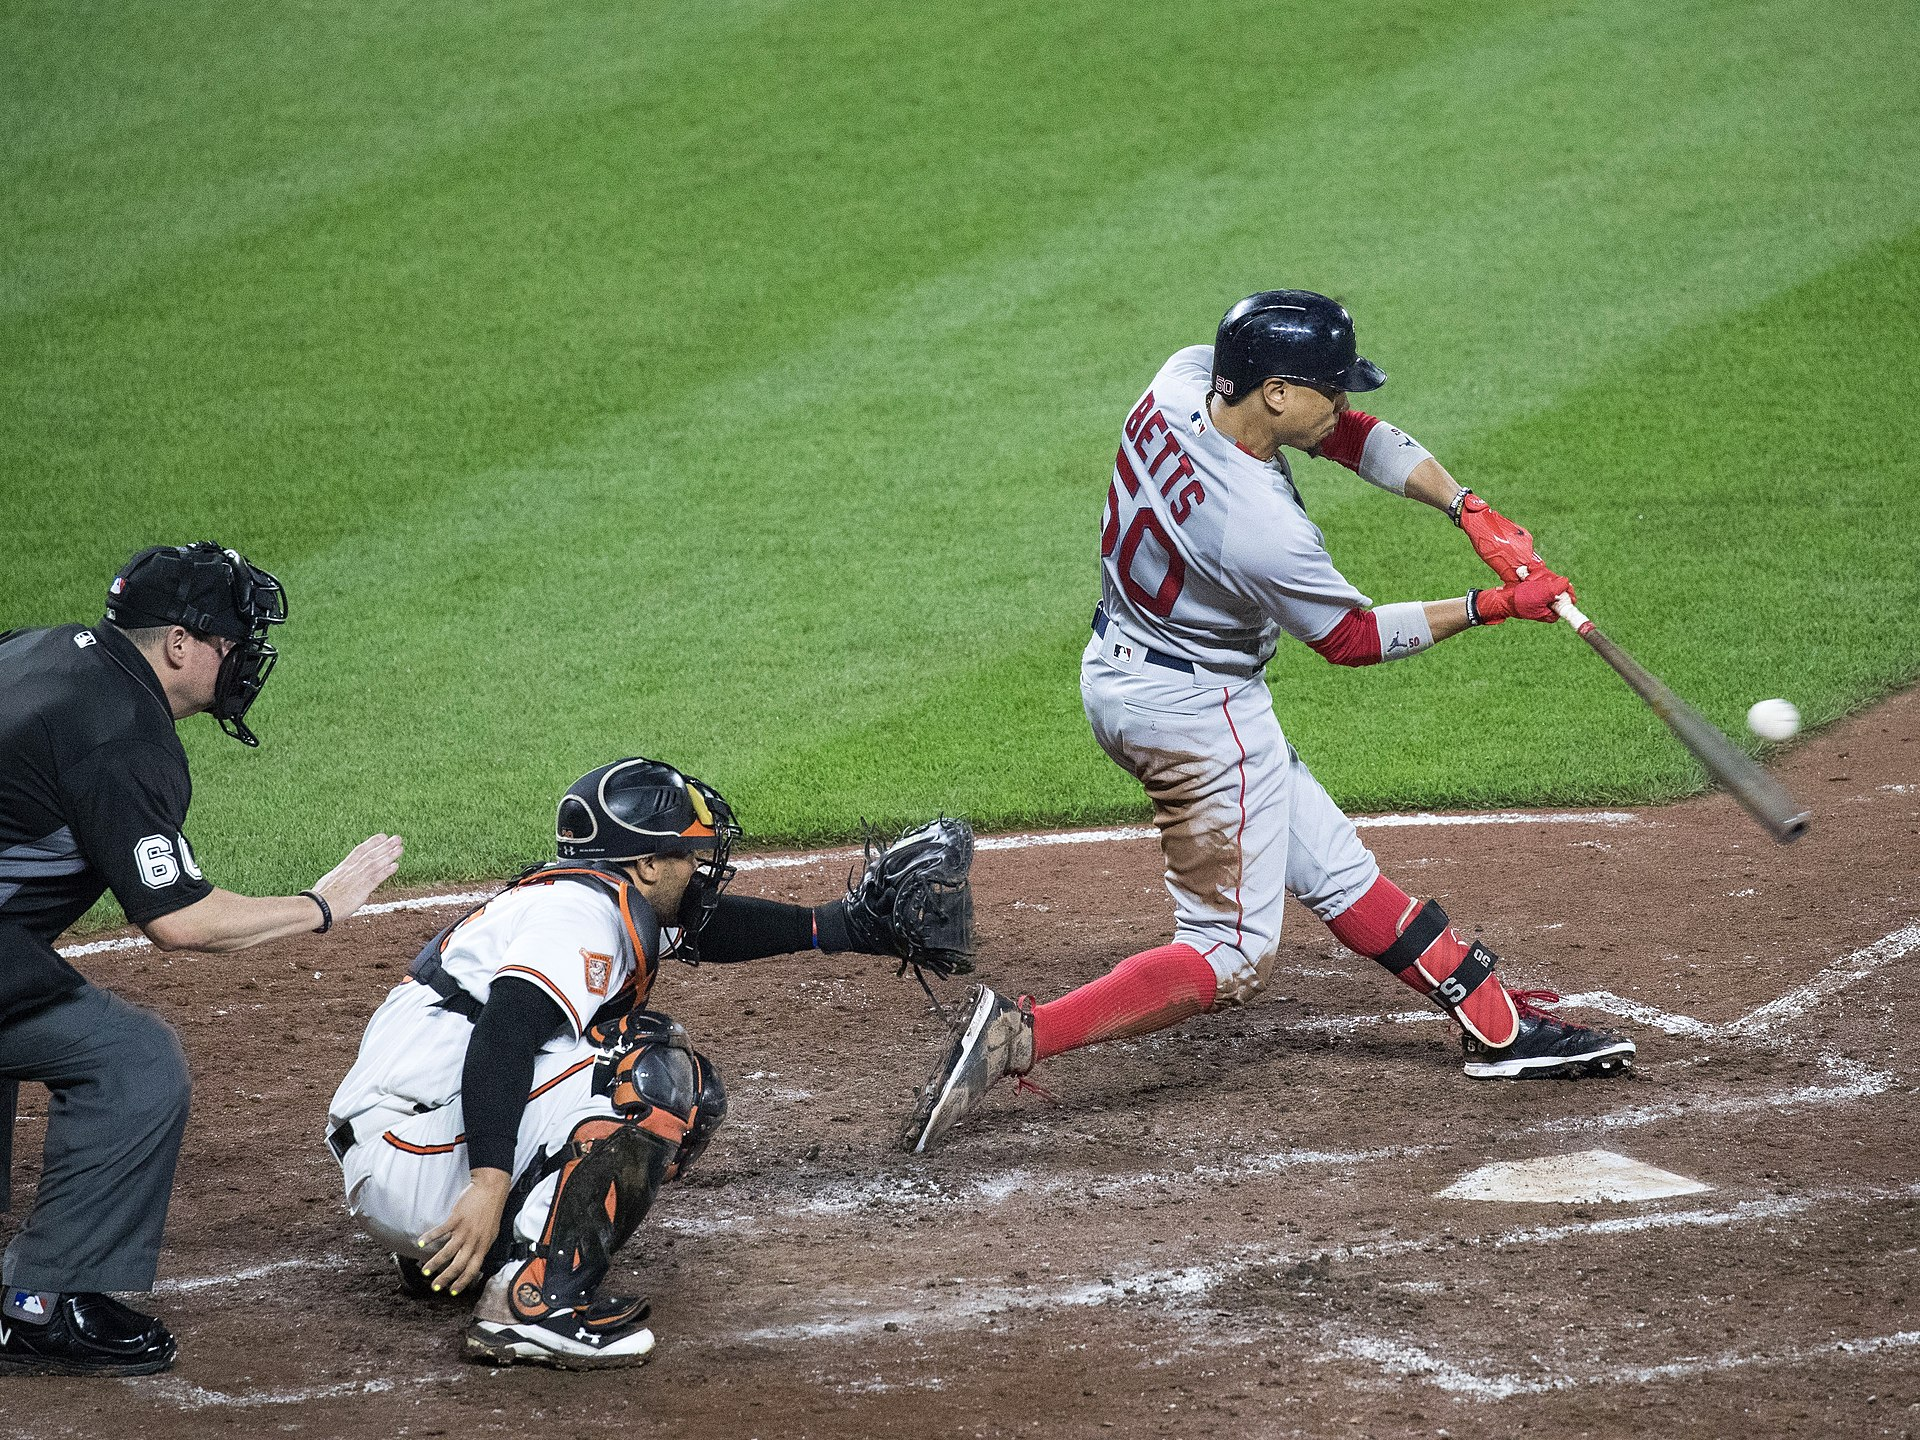
[Source](https://en.wikipedia.org/wiki/Baseball)

In baseball, like most other competitions and sports, the way to win games is score more points than your opponent. The way to do that in baseball is by hitting a baseball so that a batter can get on base and find a way to home base either by his own doing via a homerun or by collecting a string of hits before the defensive fielders can record 3 outs in a period.<br><br>
Of the major American sports, baseball has long been the most statistically-approachable sport and incorporated into roster construction for optimal performance. Within the last 10 years, satidum technology has skyrocketed in order to record more data about in-game behavior for teams to convert into productive strategies on and off the field. Teams that have a great ability to score and limit opponent scoring are often the highest achieving teams in any given season. Scoring opportunities are maximized if there are players on base that a batter can send to home plate if they are able to record a hit. <br><br>
The goal of this analysis is to consolidate data on contacted baseballs and identify the best model for predicting the outcome of contacted baseballs as well as determining the most variables that contribute to a higher hit probability on any given ball hit into play. This project will focus on MLB (major league baseball) games during the 2022 at Wrigley Field where the Chicago Cubs play their home games. 

### Data Source

The statistical data used in this project comes from `pybaseball`, a Python package for baseball data analysis. The following comes from Pybaseball's [GitHub](https://github.com/jldbc/pybaseball) page:

> This package scrapes [Baseball Reference](https://www.baseball-reference.com/), [Baseball Savant](https://baseballsavant.mlb.com/), and [FanGraphs](https://www.fangraphs.com/) so you don't have to. The package retrieves statcast data, pitching stats, batting stats, division standings/team records, awards data, and more. Data is available at the individual pitch level, as well as aggregated at the season level and over custom time periods. See the docs for a comprehensive list of data acquisition functions.

The variable descriptions for the initial, imported dataset (before preprocessing) can be found [here](https://baseballsavant.mlb.com/csv-docs) . After preprocessing, a dataframe displaying the final variable descriptions can be found in the **Column Descriptions** sub-section later in the notebook.

## Relevant Libraries and Modules

In [1]:
import sklearn
sklearn.__version__

'1.2.2'

In [2]:
RANDOM_STATE = 95

import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
simplefilter('ignore', category = ConvergenceWarning)
simplefilter('ignore', category = FitFailedWarning)
simplefilter('ignore', category = UserWarning)

In [3]:
#install pybaseball module
!pip install baseball

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Relevant `pybaseball` functions: 
[Statcast](https://github.com/jldbc/pybaseball/blob/master/pybaseball/statcast.py)
and [Plotting](https://github.com/jldbc/pybaseball/blob/master/pybaseball/plotting.py) for `pybaseball.spraychart`

In [4]:
import pybaseball
from pybaseball import statcast, spraychart

## Data Import and Preprocessing

Enable [caching function](https://github.com/jldbc/pybaseball/tree/5034834a92ab72dd55fcbc07530287a040607af1#caching) for large, repeated queries

In [5]:
pybaseball.cache.enable()

Import data from `pybaseball`:

In [6]:
every_pitch_2022 = statcast(start_dt = '2022-04-07', end_dt = '2022-10-02', #date period for 2022 regular seasion
                            verbose = False)

100%|████████████████████████████████████████████████████████████████████████████████| 179/179 [00:12<00:00, 14.53it/s]


In [7]:
every_pitch_2022.head()

pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
2747         FF 2022-10-02           93.5            1.7           5.95   
2839         CU 2022-10-02           80.9           2.06           5.59   
3001         FF 2022-10-02           92.3           1.65           5.93   
3126         FF 2022-10-02           94.3           1.65           5.93   
3162         FF 2022-10-02           93.4           1.81           5.93   

         player_name  batter  pitcher     events    description  ...  \
2747  Zastryzny, Rob  663993   642239  strikeout       foul_tip  ...   
2839  Zastryzny, Rob  663993   642239       None           ball  ...   
3001  Zastryzny, Rob  663993   642239       None           foul  ...   
3126  Zastryzny, Rob  663993   642239       None           ball  ...   
3162  Zastryzny, Rob  663993   642239       None  called_strike  ...   

      fld_score  post_away_score  post_home_score  post_bat_score  \
2747          8                3                8               3   
2839          8                3                8               3   
3001          8                3                8               3   
3126          8                3                8               3   
3162          8                3                8               3   

      post_fld_score if_fielding_alignment of_fielding_alignment spin_axis  \
2747               8              Standard              Standard       167   
2839               8              Standard              Standard       273   
3001               8              Standard              Standard       157   
3126               8              Standard              Standard       159   
3162               8              Standard              Standard       156   

     delta_home_win_exp delta_run_exp  
2747                0.0        -0.083  
2839                0.0         0.014  
3001                0.0           0.0  
3126                0.0         0.011  
3162                0.0        -0.023  

[5 rows x 92 columns]

In [8]:
every_pitch_2022.shape

(695196, 92)

### Eliminate rows based on desired conditions

Limit observations to pitches at Wrigley Field, that are hit into play, and are not bunt attempts:

In [9]:
wrigley_2022 = every_pitch_2022[(every_pitch_2022['home_team'] == 'CHC')] #limits observations to pitches at Wrigley Field

#every pitch hit into play
wrigley_2022 = wrigley_2022[(wrigley_2022['type'] == 'X')]

#drop all pitches that are categorized as sacrifice bunts, sacrifice bunt doubple plays or general bunt attempts
wrigley_2022.drop(wrigley_2022[(wrigley_2022['events'] == 'sac_bunt') |
                               wrigley_2022['des'].str.contains('bunt')].index,
                  inplace = True)

### Construct new variables that summarize multiple variables

In [10]:
wrigley_2022_newCat = wrigley_2022.copy()

#rename columns
wrigley_2022_newCat.rename(columns = {'if_fielding_alignment': 'if_alignment', 'of_fielding_alignment': 'of_alignment',
                                  'outs_when_up':'batter_outs', 'inning_topbot':'inning_half'},
                           inplace = True)

#new target variable
positive_outcomes = ['single', 'double', 'home_run', 'triple']
wrigley_2022_newCat['outcome'] = np.where(wrigley_2022_newCat['events'].isin(positive_outcomes), 'Hit', 'Non-hit')

#new hit_destination variable
wrigley_2022_newCat['hit_location'] = wrigley_2022_newCat['hit_location'].fillna(0) #set null values to 0
hit_loc_positions = ['seats', 'P', 'C', '1B', '2B', '3B', 'SS', 'LF', 'CF', 'RF']
for i in range(10): #create new variables with choice labels^
    wrigley_2022_newCat.loc[wrigley_2022_newCat['hit_location'] == i, 'hit_destination'] = hit_loc_positions[i]
    
#new pitch_count variable
for x in [0,1, 2, 3]:
    for y in [0, 1, 2]:
        wrigley_2022_newCat.loc[((wrigley_2022_newCat['balls'] == x) & (wrigley_2022_newCat['strikes'] == y)),
                             'pitch_count'] = '{}-{}'.format(x,y)    
        
#new contact_type variable
wrigley_2022_newCat = wrigley_2022_newCat[wrigley_2022_newCat['launch_speed_angle'].notna()] #remove launch_speed_angle_nulls
contact_types = ['Weak', 'Topped', 'Under', 'Flare/Burner', 'Solid', 'Barrel']
for i in range(6): #create new variables with type labels^
    wrigley_2022_newCat.loc[wrigley_2022_newCat['launch_speed_angle'] == (i+1), 'contact_type'] = contact_types[i]
    
#new score differential variables
wrigley_2022_newCat['run_diff'] = wrigley_2022_newCat['bat_score'] - wrigley_2022_newCat['fld_score']

#binarize baserunning variables
for item in ['on_1b', 'on_2b', 'on_3b']:
    wrigley_2022_newCat[item] = wrigley_2022_newCat[item].fillna(0)
    wrigley_2022_newCat.loc[wrigley_2022_newCat[item] > 0, item] = 1
    wrigley_2022_newCat[item] = np.where(wrigley_2022_newCat[item] == 1, 'yes', 'no')
    
#new month variables
wrigley_2022_newCat['game_month'] = wrigley_2022_newCat['game_date'].dt.month

### Remove variables that do not contribute to project for various reasons

[Definitions](https://baseballsavant.mlb.com/csv-docs) for every variable in the original dataset

**Identifiers**: variables that label players and teams<br>
**Estimations**: variables derived from other variables that are too highly correlated with the target variables<br>
**Deprecated**: null variables that have been replaced by newer ones but retained for older observations<br>
**Descriptions**: variables that describe the play<br>
**Score**: variables that reveal the score at different points during the pitch<br>
**Converted**: new representations of these variables exist<br>
**Dummy**: categorical variables that will be converted to dummy variables soon<br>

In [11]:
id_variables = ['player_name', 'batter', 'pitcher', 'game_type', 'game_year', 'home_team', 'away_team', 'fielder_2',
                 'umpire', 'sv_id', 'game_pk','pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
                 'fielder_7', 'fielder_8', 'fielder_9']

estimation_variables = ['estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom',
                        'babip_value', 'iso_value', 'delta_home_win_exp', 'delta_run_exp']

deprecated_variables = ['spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
                         'tfs_deprecated', 'tfs_zulu_deprecated']

description_variables = ['description', 'des', 'type', 'events', 'pitch_name','at_bat_number', 'pitch_number']

score_variables = ['game_date', 'home_score', 'away_score', 'bat_score', 'fld_score', 'post_home_score',
                 'post_away_score', 'post_bat_score','post_fld_score']

converted_variables = ['hit_location', 'launch_speed_angle', 'balls', 'strikes']

wrigley_2022_trimmedCat = wrigley_2022_newCat.copy() #new copy of dataset

wrigley_2022_trimmedCat.drop(columns = 
                          (id_variables + estimation_variables + deprecated_variables + description_variables +
                           score_variables + converted_variables),
                          inplace = True)

Drop observations with null values from dataset:

In [12]:
wrigley_2022_trimmedCat.dropna(inplace = True)

Convert categorical/ordinal variables to appropriate data type:

In [13]:
dummy_vars = ['pitch_type', 'zone', 'bb_type', 'batter_outs', 'inning', 'if_alignment', 'of_alignment', 'hit_destination',
             'pitch_count', 'contact_type', 'game_month', 'stand', 'p_throws', 'inning_half', 'on_1b', 'on_2b', 'on_3b']
dummy_dict = {}
for item in dummy_vars:
    dummy_dict[item] = 'category'
wrigley_2022_trimmedCat = wrigley_2022_trimmedCat.astype(dummy_dict)

#move target variable to last column position
wrigley_2022_trimmedCat.insert(loc = wrigley_2022_trimmedCat.shape[1]-1,
                              column = 'outcome',
                              value = wrigley_2022_trimmedCat.pop('outcome'))

### Column Descriptions

| Variable | Description |
| - | -|
| pitch_type | The type of pitch derived from Statcast |
| release_speed | Pitch velocities from Statcast, which are reported out-of-hand |
| release_pos_x | Horizontal Release Position of the ball measured in feet from the catcher's perspective |
| release_pos_z | Vertical Release Position of the ball measured in feet from the catcher's perspective |
| zone | Zone location of the ball when it crosses the plate from the catcher's perspective |
| bb_type | Batted ball type, ground_ball, line_drive, fly_ball, popup |
| pfx_x | Horizontal movement in feet from the catcher's perspective |
| pfx_z | Vertical movement in feet from the catcher's perpsective |
| plate_x | Horizontal position of the ball when it crosses home plate from the catcher's perspective |
| plate_z | Vertical position of the ball when it crosses home plate from the catcher's perspective |
| on_3b | Whether 3rd base is occupied or empty |
| on_2b | Whether 2nd base is occupied or empty |
| on_1b | Whether 1st base is occupied or empty |
| batter_outs | Pre-pitch number of outs |
| inning | Pre-pitch inning number |
| hc_x | Hit coordinate X of batted ball |
| hc_y | Hit coordinate Y of batted ball |
| vx0 | The velocity of the pitch, in feet per second, in x-dimension, determined at y=50 feet |
| vy0 | The velocity of the pitch, in feet per second, in y-dimension, determined at y=50 feet |
| vz0 | The velocity of the pitch, in feet per second, in z-dimension, determined at y=50 feet |
| ax | The acceleration of the pitch, in feet per second per second, in x-dimension, determined at y=50 feet |
| ay | The acceleration of the pitch, in feet per second per second, in y-dimension, determined at y=50 feet|
| az | The acceleration of the pitch, in feet per second per second, in z-dimension, determined at y=50 feet |
| sz_top | Top of the batter's strike zone set by the operator when the ball is halfway to the plate|
| sz_bot | Bottom of the batter's strike zone set by the operator when the ball is halfway to the plate |
| hit_distance_sc | Projected hit distance of the batted ball |
| launch_speed | Exit velocity of the batted ball as tracked by Statcast. For the limited subset of batted balls not tracked directly, estimates are included |
| launch_angle | Launch angle of the batted ball as tracked by Statcast. For the limited subset of batted balls not tracked directly, estimates are included |
| effective_speed | Derived speed based on the the extension of the pitcher's release |
| release_spin_rate | Spin rate of pitch tracked by Statcast |
| release_extension | Release extension of pitch in feet as tracked by Statcast |
| release_pos_y | Release position of pitch measured in feet from the catcher's perspective |
| if_alignment | Infield fielding alignment at the time of the pitch |
| of_alignment | Outfield fielding alignment at the time of the pitch |
| spin_axis | The Spin Axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball |
| hit_destination | Position of first fielder to touch the ball |
| pitch_count | Number of balls and strikes in at-bat count |
| contact_type | Quality of contact |
| run_diff | Difference between batter team score and fielding team score |
| game_month | Month that the game occurs |
| stand | Side of the plate batter is standing |
| p_throws | Hand pitcher throws with |
| inning_half | Pre-pitch top or bottom of inning. |
| outcome | **TARGET VARIABLE** Whether the batted ball resulted in a hit or non-hit |

## Exploratory Data Analysis

Descriptive statistics for categorical variables:

In [14]:
wrigley_2022_trimmedCat.describe(include = 'category').T

count unique          top  freq
pitch_type       3937     12           FF  1087
zone             3937     13            5   581
stand            3937      2            R  2575
p_throws         3937      2            R  2930
bb_type          3937      4  ground_ball  1774
on_3b            3937      2           no  3561
on_2b            3937      2           no  3224
on_1b            3937      2           no  2731
batter_outs      3937      3            0  1339
inning           3937     11            5   475
inning_half      3937      2          Top  2000
if_alignment     3937      3     Standard  2465
of_alignment     3937      2     Standard  3770
hit_destination  3937     10           CF   623
pitch_count      3937     12          0-0   607
contact_type     3937      6       Topped  1367
game_month       3937      7            6   856

Descriptive statistics for numeric variables:

In [15]:
wrigley_2022_trimmedCat.describe().T

count         mean         std        min         25%  \
release_speed      3937.0    88.290831    6.188933       38.4        84.2   
release_pos_x      3937.0    -0.899703    1.845292      -4.65       -2.15   
release_pos_z      3937.0      5.71208    0.564362       1.01        5.47   
pfx_x              3937.0    -0.170996    0.861423      -2.02       -0.94   
pfx_z              3937.0     0.586175    0.688991      -1.71        0.16   
plate_x            3937.0     -0.02969    0.538556      -1.83       -0.42   
plate_z            3937.0     2.324201    0.563606       0.57        1.93   
hc_x               3937.0   125.195712   39.062556       12.3      102.07   
hc_y               3937.0    125.69619   39.541513      15.75       96.35   
vx0                3937.0     2.528488     5.34021 -13.615462   -0.903108   
vy0                3937.0  -128.452147    8.982594 -146.55537 -135.097761   
vz0                3937.0    -3.392288    2.675112 -10.470656   -5.275082   
ax                 3937.0    -2.798256     10.2554 -28.990469  -11.793605   
ay                 3937.0    26.284862    3.799859   4.451845   23.661421   
az                 3937.0   -24.499197    8.190332 -47.297121  -30.210264   
sz_top             3937.0     3.347107    0.174057       2.77        3.24   
sz_bot             3937.0     1.572469    0.095198       1.22        1.52   
hit_distance_sc    3937.0   156.254001  133.289945        0.0        16.0   
launch_speed       3937.0      88.0968   14.275153       12.7        79.4   
launch_angle       3937.0    11.106934   28.732692      -84.0        -7.0   
effective_speed    3937.0     88.40348    6.415586       36.4        84.4   
release_spin_rate  3937.0  2221.891288  337.072637      675.0      2040.0   
release_extension  3937.0     6.321946     0.44806        4.0         6.0   
release_pos_y      3937.0    54.177557    0.446402      52.54       53.89   
spin_axis          3937.0   177.386081   70.718843        2.0       136.0   
run_diff           3937.0    -0.000508    3.316855      -21.0        -1.0   

                          50%         75%        max  
release_speed            89.9        92.9      100.9  
release_pos_x            -1.5        0.54        4.7  
release_pos_z            5.76        6.07       7.28  
pfx_x                   -0.26        0.52       1.82  
pfx_z                    0.68        1.13       2.22  
plate_x                 -0.04        0.37       1.76  
plate_z                  2.31        2.71        4.3  
hc_x                   123.79      152.06     235.06  
hc_y                   131.57      157.21     242.11  
vx0                  4.049747     6.29278   15.38742  
vy0               -130.772166 -122.573969 -54.717227  
vz0                 -3.644232   -1.841158  12.555114  
ax                   -2.98619    5.046433  22.356139  
ay                  26.302607   29.029128  42.086975  
az                 -24.060181  -17.806268  -6.888317  
sz_top                   3.34        3.46       3.83  
sz_bot                   1.57        1.64       1.85  
hit_distance_sc         140.0       279.0      452.0  
launch_speed             90.4        99.1      116.2  
launch_angle             12.0        29.0       88.0  
effective_speed          90.0        93.1      101.3  
release_spin_rate      2250.0      2436.0     3389.0  
release_extension         6.3         6.6        8.0  
release_pos_y           54.15       54.48      56.53  
spin_axis               201.0       222.0      356.0  
run_diff                  0.0         1.0       21.0

The majority of these numeric variables are not normally distributed as expected and any outliers that may appear can be jusitified within the context of baseball.

Pearson correlation heatmap:

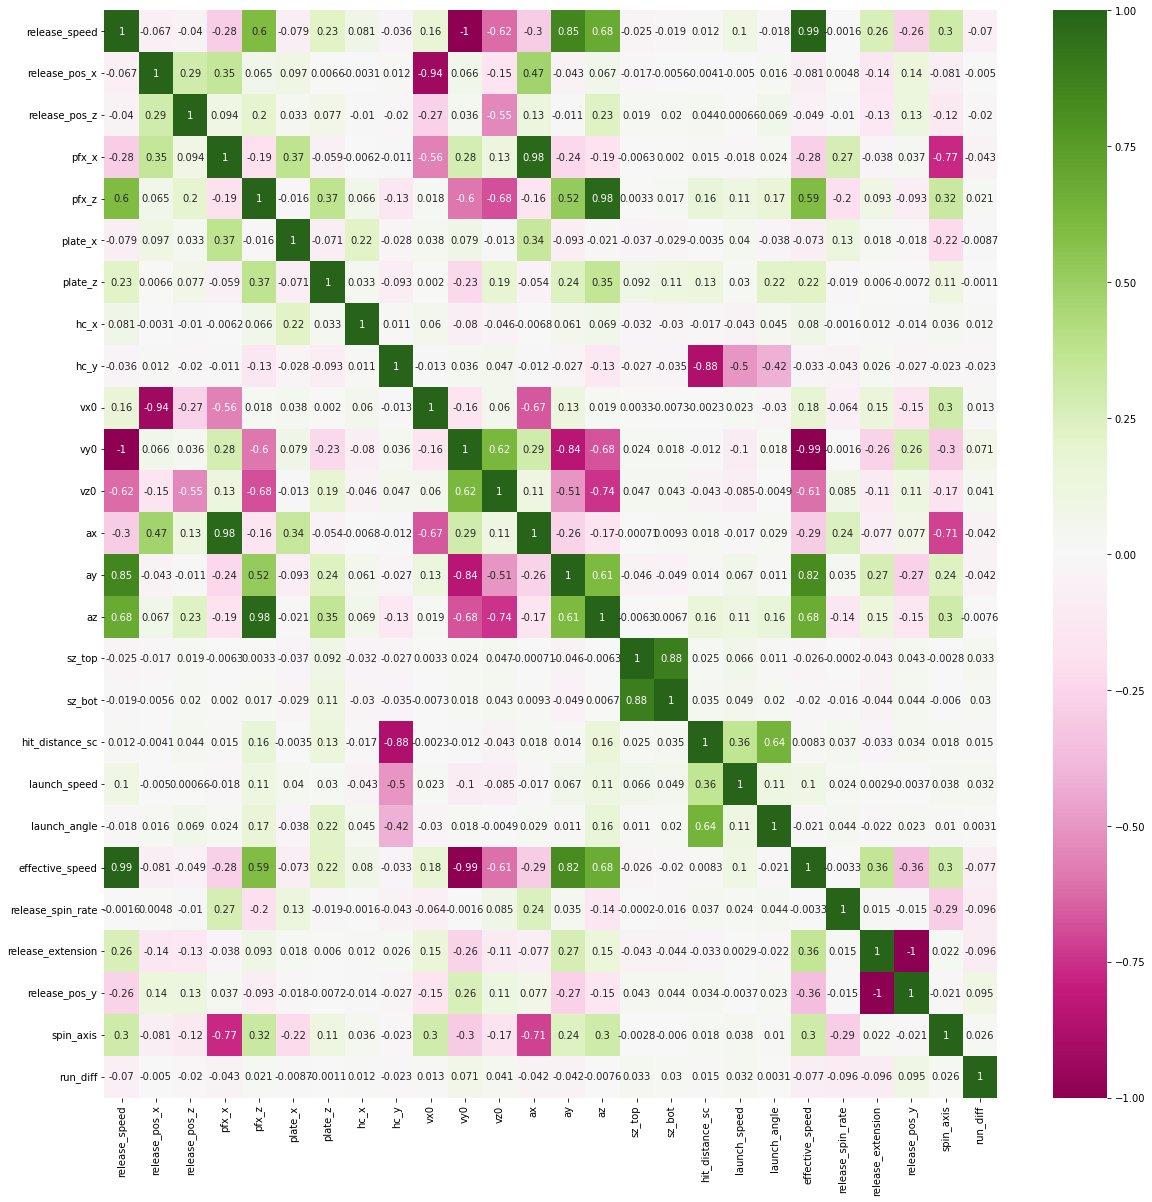

In [16]:
#specify size of heatmap
fig, ax = plt.subplots(figsize=(20, 20))

#create heatmap
ax = sns.heatmap(wrigley_2022_trimmedCat.corr(numeric_only = True), annot = True, vmin = -1, cmap = 'PiYG');

The following variables pairs are highy correlated **(>|0.9|)**:

In [17]:
corr_abs = wrigley_2022_trimmedCat.corr(numeric_only = True).abs() #absolute value correlations
corr_pairs = corr_abs.unstack() #unstack dataframe
corr_sorted = corr_pairs.sort_values(kind="quicksort", ascending = False) #sort values

#double inequality for values greater than 0.9
corr_sorted_filtered = corr_sorted[(corr_sorted > 0.9) & (corr_sorted < 1)]

#dataframe of top absolute value correlations
pd.DataFrame(data = {'Variable Pairs': corr_sorted_filtered.iloc[::2].index.tolist(),
                     'Pearson correlations': corr_sorted_filtered.iloc[::2].values},
            index = range(1, len(corr_sorted_filtered.iloc[::2])+1))

Variable Pairs  Pearson correlations
1                (release_speed, vy0)              0.999840
2  (release_pos_y, release_extension)              0.997869
3              (vy0, effective_speed)              0.994013
4    (effective_speed, release_speed)              0.993635
5                         (pfx_x, ax)              0.982778
6                         (pfx_z, az)              0.981021
7                (vx0, release_pos_x)              0.936242

These variable pairs are strongly correlated in either direction because they mostly have causal relationships (i.e. one variable is involved in the calcuation of the the other variable). 

Scatterplot of Exit Velocity vs Launch Angle:

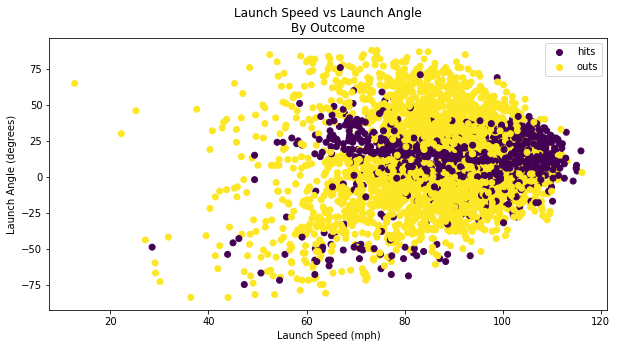

In [18]:
plt.figure(figsize = (10, 5))
temp_scatter = plt.scatter(x = wrigley_2022_trimmedCat['launch_speed'],
           y = wrigley_2022_trimmedCat['launch_angle'],
           c = wrigley_2022_trimmedCat['outcome'].astype('category').cat.codes)
plt.title('Launch Speed vs Launch Angle\nBy Outcome')
plt.xlabel('Launch Speed (mph)')
plt.ylabel('Launch Angle (degrees)')
plt.legend(handles = temp_scatter.legend_elements()[0],
          labels = ['hits', 'outs'], 
          prop={'size': 10});

While the correlation coefficient for **launch_speed** and **launch_angle** is only 0.109, there is more to the scatterplot when the data is separated by target labeling. There is clearly a sweet spot in terms of launch angle that leads to hits. If a ball is hit too high in the air (high launch angle), the fielders will have enough time to react and catch the ball before it falls for a hit. Likewise, if a batter does not hit the ball high enough, the ball will hit the ground quickly and be captured by an infielder and thrown to first base for an out. As indicated in the plot, there is generally a wider range of outcomes when the ball is hit hard enough (launch speed) regardless of angle. The few hits with negative launch angle and slower launch speed were balls that were into the ground immediately but moved slow enough on the ground for the batter to achieve a hit before a fielder could capture the ball. 

Barchart of Outcomes by Pitch-Type:

pitch_type  pitch_name     
FF          4-Seam Fastball    1099
SI          Sinker              893
SL          Slider              594
CH          Changeup            461
FC          Cutter              379
CU          Curveball           250
KC          Knuckle Curve       112
ST          Sweeper              89
FS          Split-Finger         70
SV          Slurve               28
FA          Other                23
EP          Eephus                4
dtype: int64


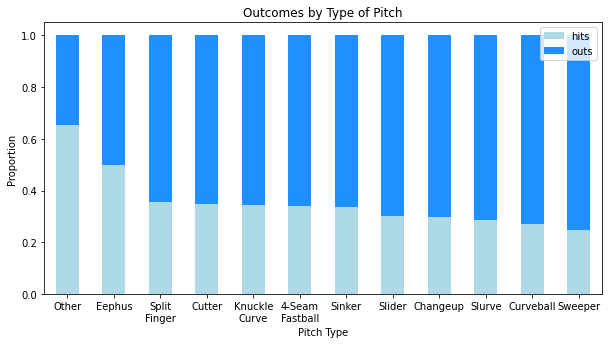

In [19]:
print(wrigley_2022[['pitch_type', 'pitch_name']].value_counts())

#out percentages
temp_outs = []
for i in (list(range(0, 5, 2)) + [7] + list(range(8, 23, 2))): #indices with non-hit percentages are
    temp_outs.append(wrigley_2022_trimmedCat.groupby(['pitch_type'])['outcome'].value_counts(normalize = True).values[i])

#hit percentages
temp_hits = []
for i in (list(range(1, 6, 2)) + [6] + list(range(9, 24, 2))): #indices with hit percentages
    temp_hits.append(wrigley_2022_trimmedCat.groupby(['pitch_type'])['outcome'].value_counts(normalize = True).values[i])

temp_index = ['Sweeper', 'Curveball', 'Slurve', 'Changeup', 'Slider', 'Sinker', '4-Seam\nFastball', 'Knuckle\nCurve',
             'Cutter', 'Split\nFinger', 'Eephus', 'Other']
temp_index.reverse()

pd.DataFrame({'hits':sorted(temp_hits, reverse = True),
              'outs':sorted(temp_outs)}, index = temp_index)\
.plot.bar(rot = 0, stacked = True, color = {'outs':'dodgerblue', 'hits':'lightblue'},
         title = 'Outcomes by Type of Pitch', figsize = (10,5),
         xlabel = 'Pitch Type', ylabel = 'Proportion');

In baseball, pitchers throw different types of pitchers towards the batter to either influence bad contact with the ball, a missed swing, or hesitation to swing at the baseball altogether. The first bar chart indicates that 4-seam fastballs, sinkers, and sliders are thrown most commonly while eephus pitches, slurves, and split-finger fastballs are thrown more sparingly. The bar chart next shows the proportion of outcomes based on each different type of pitch thrown. Of pitches thrown relatively often, hitters are most likely to create hits out of contacted **Split-finger fastballs** and least likely to create hits out of contacted **sweeper breaking balls**. 

Barchart of types of contact by outcome:

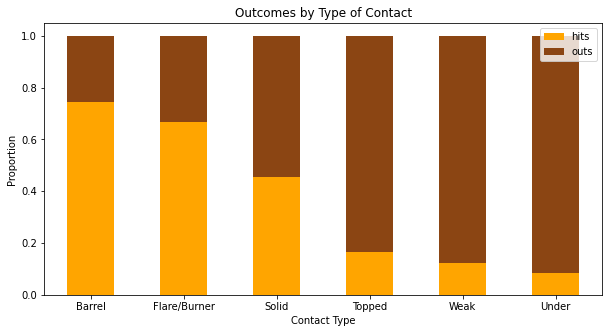

In [20]:
#out percentages
temp_outs = []
for i in ([1, 3] + list(range(4,11,2))):
    temp_outs.append(wrigley_2022_trimmedCat.groupby(['contact_type'])['outcome'].value_counts(normalize = True).values[i])

#hit percentages
temp_hits = []
for i in ([0,2] + list(range(5,12,2))):
    temp_hits.append(wrigley_2022_trimmedCat.groupby(['contact_type'])['outcome'].value_counts(normalize = True).values[i])

temp_index = ['Under', 'Weak', 'Topped', 'Solid', 'Flare/Burner', 'Barrel']
temp_index.reverse()

pd.DataFrame({'hits':sorted(temp_hits, reverse = True),
             'outs':sorted(temp_outs)}, index = temp_index)\
.plot.bar(rot = 0, stacked = True, color = {'outs':'saddlebrown', 'hits':'orange'},
         title = 'Outcomes by Type of Contact', figsize = (10,5),
         xlabel = 'Contact Type', ylabel = 'Proportion');

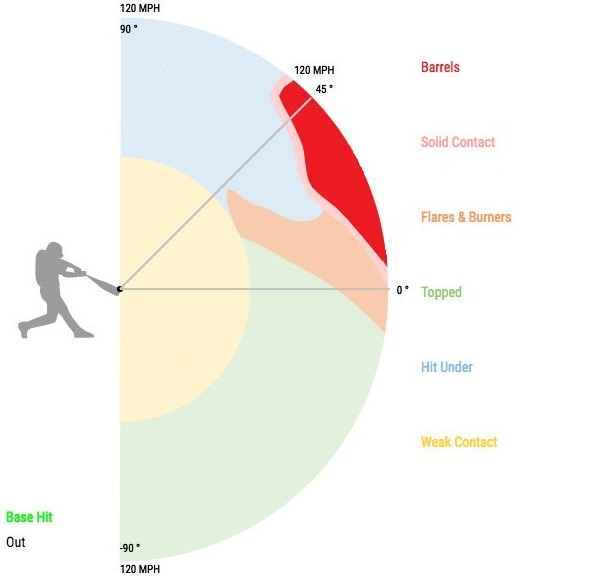
[Source](https://www.pitcherlist.com/beyond-the-barrel-an-introduction-to-ideal-contact-rate/)

The x-axis in the barchart above lists the different types of contact that can result from a batted baseball. The graphic directly below it introduces how each type of contact is defined (each is a certain combination of **launch angle** and **launch speed**). As indicated in the barchart, barrels, flare/burners, and solid contact are most likely to result in hits, relative to the rest of the options available. The less productive types of contact make it easier for fielders to react to the baseball before it reaches the ground **(hit under)** or fast enough that it can be thrown to the first baseman for an out **(topped or weak)**. 

Outcomes by Location On Field:

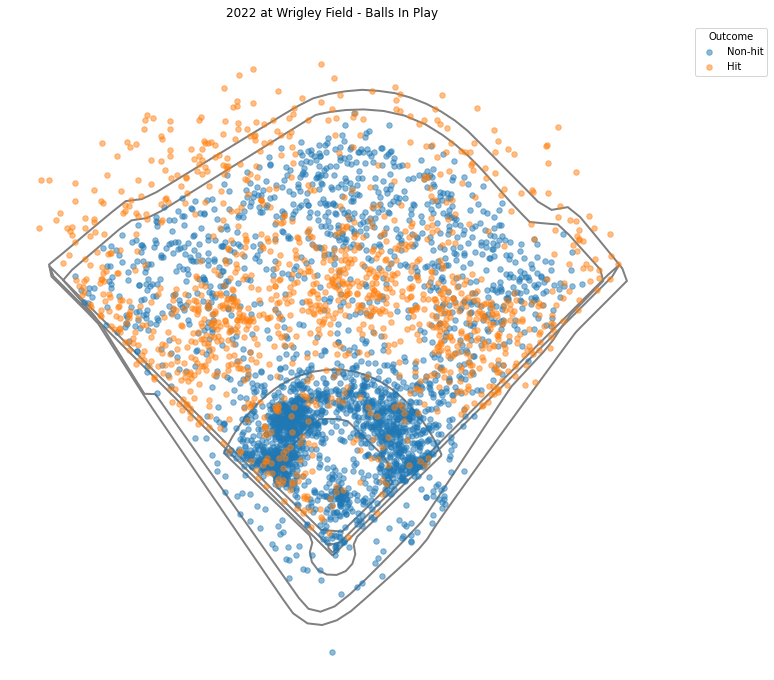

In [21]:
from pybaseball import spraychart
spraychart(data = wrigley_2022_newCat, team_stadium = 'cubs', title = '2022 at Wrigley Field - Balls In Play', size = 30, 
          colorby = 'outcome', legend_title = 'Outcome', width = 700, height = 700);

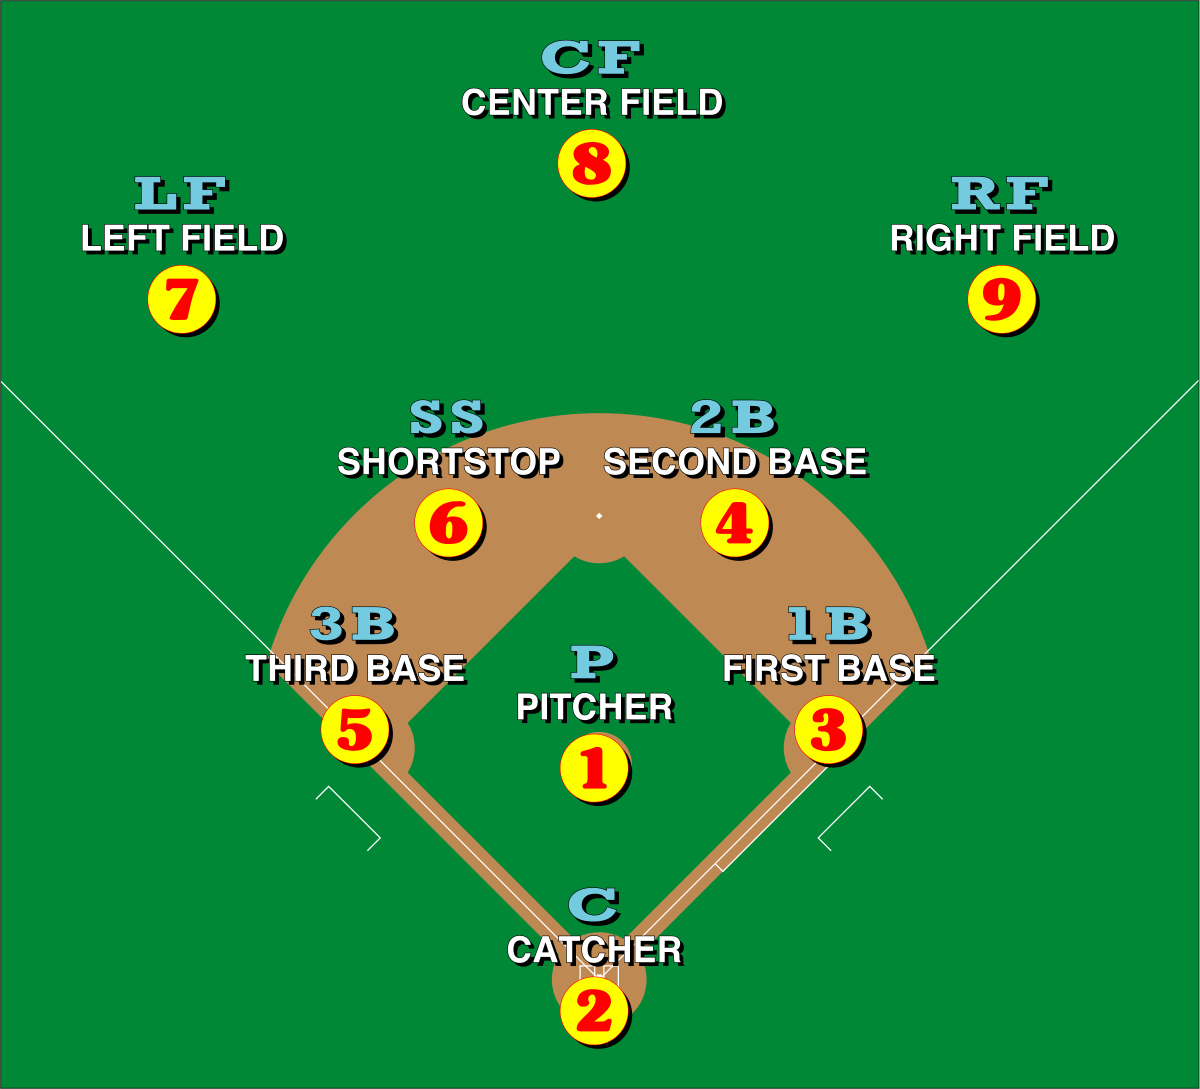
[Source](https://en.wikipedia.org/wiki/Baseball_positions)

Baseball has 9 defensive positions included in the image above. These fielders can turn contacted baseball into outs by catching the ball before it hits the ground, capturing the ball and throwing to the first baseman and a few more ways that aren't relevant to this exercise. Batters ultimately intend to hit the baseball away from fielders in most circumstances. <br><br>
The `pybaseball` library includes a `spraychart` function that can plot the outcomes of baseball events using **hc_x** and **hc_y** variables along with using the **outcome** variable to differentiate those outcomes. There are 2 distinct zones where most hits can occur. The first zone exists towards the top of the spraychart where hypothetical homeruns would be hit (which counts for four runs(points) or close enough to the outfield wall to be within catching distance of an outfielder. The second exists between in the outfield beyond the reach of the infielders but in front of the outfielders. Hits can occur in the infield as well if the balls are hit softly enough that the infielders cannot capture and throw the ball to the first baseman before the batter can reach first base.

Overlayed histogram of Hit Coordinate Y of Batted Ball (by Outcome):

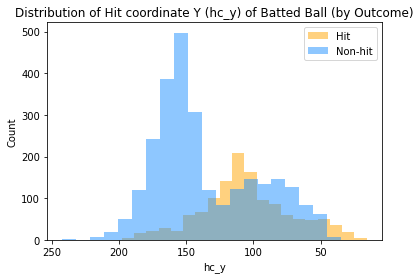

In [22]:
plt.hist(x=wrigley_2022_trimmedCat[wrigley_2022_trimmedCat['outcome'] == 'Hit']['hc_y'],
        alpha = 0.5, bins = 20, label = 'Hit', color = 'orange')
plt.hist(x=wrigley_2022_trimmedCat[wrigley_2022_trimmedCat['outcome'] == 'Non-hit']['hc_y'],
        alpha = 0.5, bins = 20, label = 'Non-hit', color = 'dodgerblue')
plt.legend(loc = 'upper right')
plt.title('Distribution of Hit coordinate Y (hc_y) of Batted Ball (by Outcome)')
plt.gca().invert_xaxis() #inverts the x-axis
plt.xlabel('hc_y')
plt.ylabel('Count')
plt.show;

This overlayed histogram is a more statistically-familiar way of representing the spraychart above. The distribution of non-hit locations is relatively binomial while the distribution of hit locations is normal. 

## Data Preparation (for Machine Learning)

Dummy variable conversion and reset index:

In [23]:
wrigley_2022_dummy = wrigley_2022_trimmedCat.copy() #new copy of dataset
wrigley_2022_dummy['outcome'] = np.where(wrigley_2022_dummy['outcome'] == 'Hit', 1, 0) #binarize target variable
wrigley_2022_dummy = pd.get_dummies(wrigley_2022_dummy) #create dummy variables for categorical variables
wrigley_2022_dummy = wrigley_2022_dummy.iloc[::-1]#.reset_index(drop = True)

#move target variable to last column position
wrigley_2022_dummy.insert(loc = wrigley_2022_dummy.shape[1]-1,
                              column = 'outcome',
                              value = wrigley_2022_dummy.pop('outcome'))

Separate target variable **(outcome)**: 

In [24]:
y = wrigley_2022_dummy['outcome']
X = wrigley_2022_dummy.drop(['outcome'], axis = 1)

Split dataset into training, validation, and test sets:

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = RANDOM_STATE)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = RANDOM_STATE)

Normalize the training set and apply the fits to the validation and test sets:

In [26]:
mm_scaler = MinMaxScaler() #initiate the scaler
mm_scaler.fit(X_train)
X_train = mm_scaler.transform(X_train)
X_val = mm_scaler.transform(X_val)
X_test = mm_scaler.transform(X_test)

## Utility Functions

Generalized classification function that returns a confusion matrix and evaluation metrics:

In [27]:
def generalized_clf(clf, train_dep, train_ind, unseen_dep, unseen_ind, test_set = False):
    """takes a classification model, training data, and validation (or test) data as input, 
    returns an aesthetic confusion matrix, and prints/returns the following evaluation metrics as a list:
    
    Recall (Sensitivity)
    Specificity
    Precision
    Balanced Accuracy
    F1 Score"""
    
    clf.fit(train_dep, train_ind) #fit model to training data
    dep_pred_unseen = clf.predict(unseen_dep) #prediction on unseen data
    conf_mat = confusion_matrix(unseen_ind, dep_pred_unseen) #confusion matrix
    
    #nicer confusion matrix production
    sequential = ['Blues', 'Greens', 'Oranges', 'Purples', 'Reds'] #sequential color pallettes
    sns.heatmap(conf_mat, annot=True, cmap = random.choice(sequential), fmt="d") #colors chosen at random
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    #evaluation metrics (based on confusion matrix and module metrics)
    tn = conf_mat[0,0] #true negative
    fp = conf_mat[0,1] #false positive
    fn = conf_mat[1,0] #false negative
    tp = conf_mat[1,1] #true positive
    
    unseen_recall = recall_score(unseen_ind, dep_pred_unseen) #unseen recall
    unseen_specificity = tn/(tn + fp) #unseen specificity
    unseen_precision = precision_score(unseen_ind, dep_pred_unseen) #unseen precision
    unseen_balanced_accuracy = balanced_accuracy_score(unseen_ind, dep_pred_unseen) #unseen balanced accuracy
    unseen_f1 = f1_score(unseen_ind, dep_pred_unseen) #unseen f1 score
    
    if test_set == False:
        print('Metrics on the validation set:\n')
    else:
        print('Metrics on the test set:\n')
    
    print('Recall (Sensitivity):', round(unseen_recall, 5))   
    print('Specificity:', round(unseen_specificity, 5))
    print('Precision:', round(unseen_precision, 5))
    print('Balanced Accuracy:', round(unseen_balanced_accuracy, 5))
    print('F1 Score:', round(unseen_f1, 5))
    
    return [round(x, 5) for x in
            [unseen_recall, unseen_specificity, unseen_precision, unseen_balanced_accuracy, unseen_f1]]

Generalized hyper-parameter tuning function that returns a confusion matrix and evaluation metrics:

In [28]:
def generalized_tuning_grid(clf, params_space, train_dep, train_ind, unseen_dep, unseen_ind):
    """takes a classification model, parameter grid space, training data, and validation data as input
    and returns a classification model with updated hyperparameters from the results of a grid search of the 
    provided parameter grid space"""
    
    grid_search = GridSearchCV(clf, param_grid = params_space, scoring = 'f1') #use 5-fold cross-validation
    grid_search.fit(train_dep, train_ind)  # Fit the grid search to training data
    
    for param in grid_search.best_params_.keys(): #print best values for parameters
        print(f"Best {param}: {grid_search.best_params_[param]}")
    print("Best Score:", round(grid_search.best_score_, 4))
    
    clf.set_params(**grid_search.best_params_) #sets classifier to best parameters from gridsearch
    
    return clf

Model comparison dataframes for classifiers:

In [29]:
clf_eval_metrics = ['Recall', 'Specificity', 'Precision', 'Balanced Accuracy', 'F1 Score']
all_params_dict = {} #storing parameters from all the models
clf_comp_df = pd.DataFrame(index = clf_eval_metrics)
clf_comp_df_test = pd.DataFrame(index = clf_eval_metrics)

## Initial Classifiers

Logistic Regression:

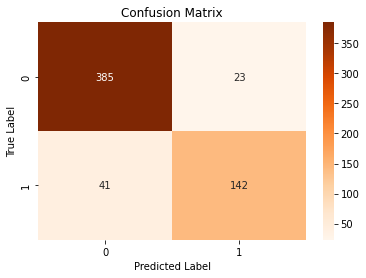

Metrics on the validation set:

Recall (Sensitivity): 0.77596
Specificity: 0.94363
Precision: 0.86061
Balanced Accuracy: 0.85979
F1 Score: 0.81609


In [30]:
estimator = LogisticRegression(max_iter=1000, random_state = RANDOM_STATE, n_jobs = -2, solver='saga')
all_params_dict['Default LR'] = estimator.get_params()
clf_comp_df['Default LR'] = generalized_clf(estimator, X_train, y_train, X_val, y_val)

Decision Tree:

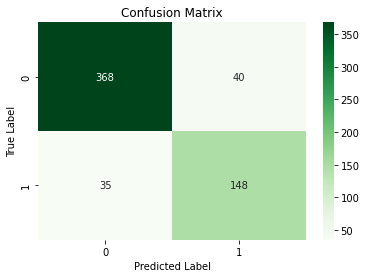

Metrics on the validation set:

Recall (Sensitivity): 0.80874
Specificity: 0.90196
Precision: 0.78723
Balanced Accuracy: 0.85535
F1 Score: 0.79784


In [31]:
estimator = DecisionTreeClassifier(random_state = RANDOM_STATE)
all_params_dict['Default DT'] = estimator.get_params()
clf_comp_df['Default DT'] = generalized_clf(estimator, X_train, y_train, X_val, y_val)

Random Forest:

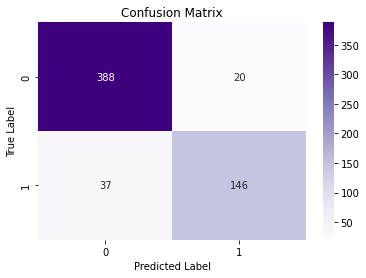

Metrics on the validation set:

Recall (Sensitivity): 0.79781
Specificity: 0.95098
Precision: 0.87952
Balanced Accuracy: 0.8744
F1 Score: 0.83668


In [32]:
estimator = RandomForestClassifier(random_state = RANDOM_STATE)
all_params_dict['Default RF'] = estimator.get_params()
clf_comp_df['Default RF'] = generalized_clf(estimator, X_train, y_train, X_val, y_val)

AdaBoost (Adaptive Boosting):

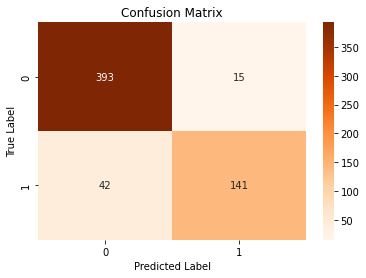

Metrics on the validation set:

Recall (Sensitivity): 0.77049
Specificity: 0.96324
Precision: 0.90385
Balanced Accuracy: 0.86686
F1 Score: 0.83186


In [33]:
estimator = AdaBoostClassifier(random_state = RANDOM_STATE)
all_params_dict['Default AB'] = estimator.get_params()
clf_comp_df['Default AB'] = generalized_clf(estimator, X_train, y_train, X_val, y_val)

Gradient Boosting:

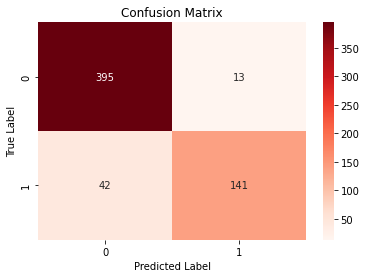

Metrics on the validation set:

Recall (Sensitivity): 0.77049
Specificity: 0.96814
Precision: 0.91558
Balanced Accuracy: 0.86931
F1 Score: 0.8368


In [34]:
estimator = GradientBoostingClassifier(random_state = RANDOM_STATE)
all_params_dict['Default GB'] = estimator.get_params()
clf_comp_df['Default GB'] = generalized_clf(estimator, X_train, y_train, X_val, y_val)

Neural Network (Multi-layer Perceptron):

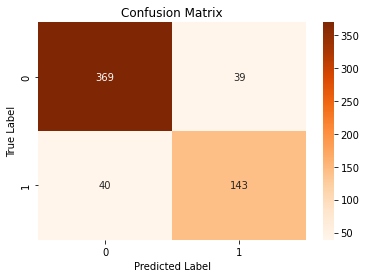

Metrics on the validation set:

Recall (Sensitivity): 0.78142
Specificity: 0.90441
Precision: 0.78571
Balanced Accuracy: 0.84292
F1 Score: 0.78356


In [35]:
estimator = MLPClassifier(random_state = RANDOM_STATE, max_iter = 400)
all_params_dict['Default NN'] = estimator.get_params()
clf_comp_df['Default NN'] = generalized_clf(estimator, X_train, y_train, X_val, y_val)

In [36]:
clf_comp_df.T.sort_values('F1 Score', ascending = False)

Recall  Specificity  Precision  Balanced Accuracy  F1 Score
Default GB  0.77049      0.96814    0.91558            0.86931   0.83680
Default RF  0.79781      0.95098    0.87952            0.87440   0.83668
Default AB  0.77049      0.96324    0.90385            0.86686   0.83186
Default LR  0.77596      0.94363    0.86061            0.85979   0.81609
Default DT  0.80874      0.90196    0.78723            0.85535   0.79784
Default NN  0.78142      0.90441    0.78571            0.84292   0.78356

The **gradient boosting** and **random forest** classifier performed the best when applied to validation data, relative to the other default classifiers. **F1 Score** is the primary evaluation metric in this analysis because the distribution of outcomes (hits and non-hits) is imbalanced. In addition, the goal is to predict outcomes rather than focus specifically on one class over another. 

## Grid Search for Optimal Models

### Logistic Regression Optimization:

Type and extent of regularization are two types of hyperparameters that impact the performance of logistic regression classifiers. There are three types of regularizations:
- L1 Regularization (lasso)
    - Penalizes the magnitude or sum of absolute values of the variables' coefficients which can lead to feature selection since coefficient values can reduced to 0
- L2 Regularization (ridge regression)
    - Penalizes the sum of squares of the variables' coefficients which doesn't perform feature selection since coefficient values only approach 0
- Elastic net regularization
    - Incorporates both L1 and L2 penalties based on a certain alpha value (which determines the ratio of the penalties involved)
    
The **penalty** hyperparameter will represent that choice while **C** represents the inverse of regularization strength.    

Best C: 10
Best penalty: elasticnet
Best Score: 0.8405


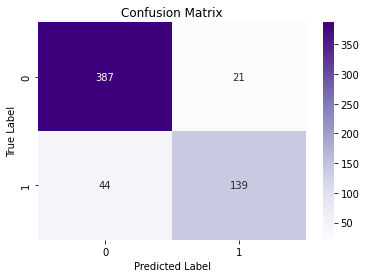

Metrics on the validation set:

Recall (Sensitivity): 0.75956
Specificity: 0.94853
Precision: 0.86875
Balanced Accuracy: 0.85405
F1 Score: 0.8105


In [37]:
#initiate logistic regression classifier
estimator = LogisticRegression(max_iter=1000, random_state = RANDOM_STATE, n_jobs = -2, solver='saga', l1_ratio = 0.5)

#specify the parameter grid for grid search
param_grid = {'penalty': ['elasticnet', 'l1', 'l2', None], # norm of the penalty
             'C': [0.001, 0.01, .1, 1, 10]} # inverse of regularization strength

estimator = generalized_tuning_grid(estimator, param_grid, X_train, y_train, X_val, y_val) #update parameters
all_params_dict['Optimal LR'] = estimator.get_params()
clf_comp_df['Optimal LR'] = generalized_clf(estimator, X_train, y_train, X_val, y_val)

In [38]:
clf_comp_df.T.loc[['Default LR', 'Optimal LR']]

Recall  Specificity  Precision  Balanced Accuracy  F1 Score
Default LR  0.77596      0.94363    0.86061            0.85979   0.81609
Optimal LR  0.75956      0.94853    0.86875            0.85405   0.81050

The logistic regression classifier **regressed slightly** after hyperparameter tuning given that the tuned model's F1 score decreased by 0.5 percentage points.

### Decision Tree Optimization:

Decision trees have three major hyperparameters (among others) that impact the quality of the model: 
- **max_depth** (maximum depth of tree)
    - As maximum depth of the decision tree increases, overfitting to the training data is more likely to occur.
- **min_samples_split** (minimum number of samples required to split an internal node)
    - As this value increases, the number of parental node splits decreases and the model becomes simpler and limits overfitting. 
- **min_samples_leaf** (minimum number of samples required to be at a leaf node)
    - As this value increases, the number of leaf nodes decreases and the model becomes simpler and limits overfitting as well. 

Best max_depth: 10
Best min_samples_leaf: 10
Best min_samples_split: 25
Best Score: 0.8324


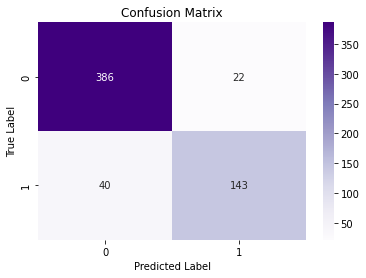

Metrics on the validation set:

Recall (Sensitivity): 0.78142
Specificity: 0.94608
Precision: 0.86667
Balanced Accuracy: 0.86375
F1 Score: 0.82184


In [39]:
estimator = DecisionTreeClassifier(random_state = RANDOM_STATE) #initiate decision tree classifier

#specify the parameter grid for grid search
param_grid = {'max_depth': range(1,11), # maximum depth of the tree
             'min_samples_split': [20, 25, 30], # minimum number of samples required to split an internal node
             'min_samples_leaf': [5, 10, 15]} # minimum number of samples required to be at a leaf node

estimator = generalized_tuning_grid(estimator, param_grid, X_train, y_train, X_val, y_val) #update parameters
base_dt_clf = estimator
all_params_dict['Optimal DT'] = estimator.get_params()
clf_comp_df['Optimal DT'] = generalized_clf(estimator, X_train, y_train, X_val, y_val)

In [40]:
clf_comp_df.T.loc[['Default DT', 'Optimal DT']]

Recall  Specificity  Precision  Balanced Accuracy  F1 Score
Default DT  0.80874      0.90196    0.78723            0.85535   0.79784
Optimal DT  0.78142      0.94608    0.86667            0.86375   0.82184

The decision tree classifier **improved** after hyperparameter tuning given that the tuned model's F1 score increased by 2.5 percentage points.

### Random Forest Optimization:

Please refer to the Decision Tree Optimization because these two sections share the same hyperparameters:
- **max_depth**
- **min_samples_split**
- **min_samples_leaf**

Best max_depth: 10
Best min_samples_leaf: 5
Best min_samples_split: 20
Best Score: 0.8404


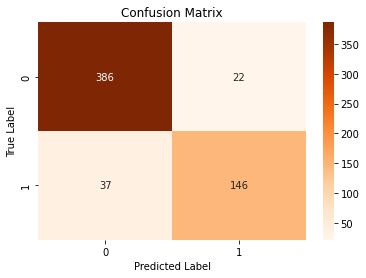

Metrics on the validation set:

Recall (Sensitivity): 0.79781
Specificity: 0.94608
Precision: 0.86905
Balanced Accuracy: 0.87195
F1 Score: 0.83191


In [41]:
estimator = RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = -2) #initiate random forest classifier

#specify the parameter grid for grid search
param_grid = {'max_depth': range(1,11), # maximum depth of the tree
             'min_samples_split': [20, 25, 30], # minimum number of samples required to split an internal node
             'min_samples_leaf': [5, 10, 15]} # minimum number of samples required to be at a leaf node

estimator = generalized_tuning_grid(estimator, param_grid, X_train, y_train, X_val, y_val) #update parameters
all_params_dict['Optimal RF'] = estimator.get_params()
clf_comp_df['Optimal RF'] = generalized_clf(estimator, X_train, y_train, X_val, y_val)

In [42]:
clf_comp_df.T.loc[['Default RF', 'Optimal RF']]

Recall  Specificity  Precision  Balanced Accuracy  F1 Score
Default RF  0.79781      0.95098    0.87952            0.87440   0.83668
Optimal RF  0.79781      0.94608    0.86905            0.87195   0.83191

The random forest classifier **regressed slightly** after hyperparameter tuning given that the tuned model's F1 score decreased by 0.5 percentage points.

### AdaBoost Optimization:

The **learning rate** in an AdaBoost classifier detemerines the weight applied to each classifier at each boosting iteraction. Therefore, a greater learning rate increases the contribution of each classifier. If the learning rate is too high, however, the model performance may decrease because the classifier applies too much weight to earlier models.

Best learning_rate: 0.01
Best Score: 0.8446


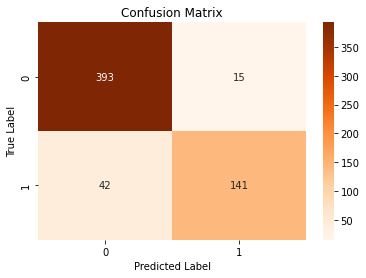

Metrics on the validation set:

Recall (Sensitivity): 0.77049
Specificity: 0.96324
Precision: 0.90385
Balanced Accuracy: 0.86686
F1 Score: 0.83186


In [43]:
estimator = AdaBoostClassifier(random_state = RANDOM_STATE, estimator = base_dt_clf) #initiate AdaBoost classifier

#specify the parameter grid for grid search
param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1]} # weight applied to each classifier at each boosting iteration

estimator = generalized_tuning_grid(estimator, param_grid, X_train, y_train, X_val, y_val) #update parameters
all_params_dict['Optimal AB'] = estimator.get_params()
clf_comp_df['Optimal AB'] = generalized_clf(estimator, X_train, y_train, X_val, y_val)

In [44]:
clf_comp_df.T.loc[['Default AB', 'Optimal AB']]

Recall  Specificity  Precision  Balanced Accuracy  F1 Score
Default AB  0.77049      0.96324    0.90385            0.86686   0.83186
Optimal AB  0.77049      0.96324    0.90385            0.86686   0.83186

The AdaBoost classifier **yielded the same values** after hyperparameter tuning. It turns out that decreasing the value for learning rate did not have affect the classifier's ability to produce a different meta-estimator. 

### Gradient Boosting Optimization:

Please refer to the AdaBoost Optimization because these two sections share the same hyperparameter **(learning_rate)**.

Best learning_rate: 0.1
Best Score: 0.8637


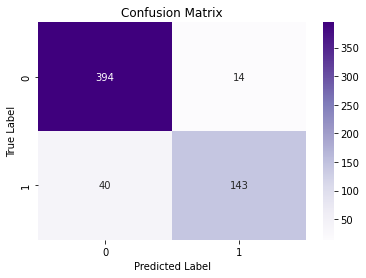

Metrics on the validation set:

Recall (Sensitivity): 0.78142
Specificity: 0.96569
Precision: 0.91083
Balanced Accuracy: 0.87355
F1 Score: 0.84118


In [45]:
estimator = GradientBoostingClassifier(random_state = RANDOM_STATE) #initiate Gradient Boosting classifier

#applying parameters from the base decision tree to the Gradient boosting machine
custom_params = {}
for key in ['max_depth', 'min_samples_split', 'min_samples_leaf']:
    custom_params[key] = base_dt_clf.get_params()[key]
estimator.set_params(**custom_params) 

#specify the parameter grid for grid search
param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1]} # weight applied to each classifier at each boosting iteration

estimator = generalized_tuning_grid(estimator, param_grid, X_train, y_train, X_val, y_val) #update parameters
all_params_dict['Optimal GB'] = estimator.get_params()
clf_comp_df['Optimal GB'] = generalized_clf(estimator, X_train, y_train, X_val, y_val)

In [46]:
clf_comp_df.T.loc[['Default GB', 'Optimal GB']]

Recall  Specificity  Precision  Balanced Accuracy  F1 Score
Default GB  0.77049      0.96814    0.91558            0.86931   0.83680
Optimal GB  0.78142      0.96569    0.91083            0.87355   0.84118

The Gradient Boosting classifier **improved slightly** after hyperparameter tuning given that the tuned model's F1 score increased by 0.5 percentage points.

### Neural Network Optimization:

Two key hyperparameters within a neural network are **the stucture of its hidden layers** and the **activation function** for those hidden layers. Located inbetween input layers and output layers, a hidden layer is where neurons (or perceptrons) accept weighted inputs and produce an output that is then provided as input for a following activation function. An activation function then is used to determine an output value for a given node based on the input it receives. 
-  There are three targeted types of activation functions as follows:
    - Logistic (Sigmoid)
        - Normalizes the output of a given node to values between 0 and 1
    - Tanh
        - Behaves similarly to sigmoid activation except the range of values is between 0 and 1
    - ReLu (Rectified Linear Unit)
        - Normalizes output of a given node to values between 0 and infinity

Best activation: logistic
Best hidden_layer_sizes: (50, 50, 50)
Best Score: 0.8347


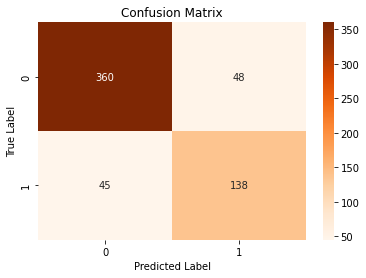

Metrics on the validation set:

Recall (Sensitivity): 0.7541
Specificity: 0.88235
Precision: 0.74194
Balanced Accuracy: 0.81823
F1 Score: 0.74797


In [47]:
estimator = MLPClassifier(random_state = RANDOM_STATE, max_iter = 1000) #initiate multi-layer perceptron classifier

#specify the parameter grid for grid search
param_grid = {'hidden_layer_sizes': [(50, 50), (100, 50), (50, 50, 50)] , # number of neurons in the ith hidden layer
             'activation': ['logistic', 'tanh', 'relu']} # activation function for the hidden layer

estimator = generalized_tuning_grid(estimator, param_grid, X_train, y_train, X_val, y_val) #update parameters
all_params_dict['Optimal NN'] = estimator.get_params()
clf_comp_df['Optimal NN'] = generalized_clf(estimator, X_train, y_train, X_val, y_val)

In [48]:
clf_comp_df.T.loc[['Default NN', 'Optimal NN']]

Recall  Specificity  Precision  Balanced Accuracy  F1 Score
Default NN  0.78142      0.90441    0.78571            0.84292   0.78356
Optimal NN  0.75410      0.88235    0.74194            0.81823   0.74797

The Neural Network classifier **regressed** after hyperparameter tuning given that the tuned model's F1 score decreased by over 3.5 percentage points.

In [49]:
clf_comp_df.T.loc[['Optimal LR', 'Optimal DT', 'Optimal RF', 'Optimal AB','Optimal GB', 'Optimal NN']]\
.sort_values('F1 Score', ascending = False)

Recall  Specificity  Precision  Balanced Accuracy  F1 Score
Optimal GB  0.78142      0.96569    0.91083            0.87355   0.84118
Optimal RF  0.79781      0.94608    0.86905            0.87195   0.83191
Optimal AB  0.77049      0.96324    0.90385            0.86686   0.83186
Optimal DT  0.78142      0.94608    0.86667            0.86375   0.82184
Optimal LR  0.75956      0.94853    0.86875            0.85405   0.81050
Optimal NN  0.75410      0.88235    0.74194            0.81823   0.74797

After hyperparameter tuning each model, the tuned **gradient boosting classifier** performed the best on validation data, relative to other tuned classifiers. As mentioned, the **decision tree** showed the greatest improvment while the **neural network** regressed the most.

## Final Models

Classifier evaluation metrics on validation set:

In [50]:
clf_comp_df.T.sort_values('F1 Score', ascending = False)

Recall  Specificity  Precision  Balanced Accuracy  F1 Score
Optimal GB  0.78142      0.96569    0.91083            0.87355   0.84118
Default GB  0.77049      0.96814    0.91558            0.86931   0.83680
Default RF  0.79781      0.95098    0.87952            0.87440   0.83668
Optimal RF  0.79781      0.94608    0.86905            0.87195   0.83191
Default AB  0.77049      0.96324    0.90385            0.86686   0.83186
Optimal AB  0.77049      0.96324    0.90385            0.86686   0.83186
Optimal DT  0.78142      0.94608    0.86667            0.86375   0.82184
Default LR  0.77596      0.94363    0.86061            0.85979   0.81609
Optimal LR  0.75956      0.94853    0.86875            0.85405   0.81050
Default DT  0.80874      0.90196    0.78723            0.85535   0.79784
Default NN  0.78142      0.90441    0.78571            0.84292   0.78356
Optimal NN  0.75410      0.88235    0.74194            0.81823   0.74797

The **optimized gradient boosting** classifier produced the highest F1 score of every model applied to the validation set. Overall, the gradient boosting classifiers outperformed every other type of classifier, regardless of the hyperparameter tuning. The second and third best types of classifiers were the **random forest** and **AdaBoost** classifier, respectively, although, as previously mentioned, the default classifiers for these two types outperformed their optimized equivalents. Ultimately, the neural network would result in the worst performing models, regardless of classifier type.<br><br>
For final testing, the **optimal gradient boosting** classifier and the **optimal random forest** classifier were chosen because their hyperparameters would theoretically be more robust to unseen data and not overfit to training data (even if that didn't occur with the validation set).<br><br>
In addition, two additional ensemble classifiers will be applied to the test set:
- Voting classifier that combines the two best optimized classifiers (and their corresponding hyperparameters)
    - Gradient boost and random forest
- Voting classifier that combines the two best default classifiers (and their corresponding hyperparameters)
    - Gradient boost and random forest

Each voting classifier will incorporate soft voting which means the output class for each instance will be maded based on the average probability given to that class from each inputted model.

Optimized Gradient Boosting (on test set):

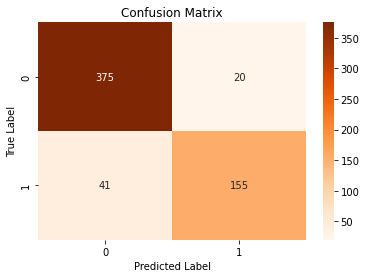

Metrics on the test set:

Recall (Sensitivity): 0.79082
Specificity: 0.94937
Precision: 0.88571
Balanced Accuracy: 0.87009
F1 Score: 0.83558


In [51]:
#Optimized Gradient boosting machine on test set
estimator = GradientBoostingClassifier().set_params(**all_params_dict['Optimal GB'])
clf_comp_df_test['Optimal GB'] = generalized_clf(estimator, X_train, y_train, X_test, y_test, test_set = True)

Optimized AdaBoost (on test set):

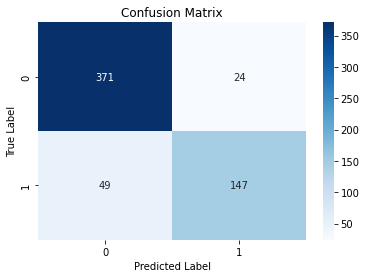

Metrics on the test set:

Recall (Sensitivity): 0.75
Specificity: 0.93924
Precision: 0.85965
Balanced Accuracy: 0.84462
F1 Score: 0.80109


In [52]:
#Optimized AdaBoost classifier on test set
estimator = RandomForestClassifier().set_params(**all_params_dict['Optimal RF'])
clf_comp_df_test['Optimal RF'] = generalized_clf(estimator, X_train, y_train, X_test, y_test, test_set = True)

Voting classifier with best optimized models (on test set):

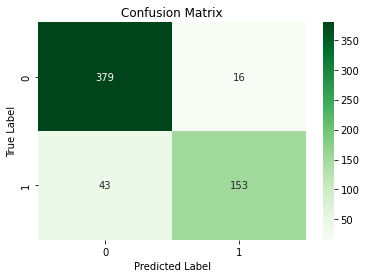

Metrics on the test set:

Recall (Sensitivity): 0.78061
Specificity: 0.95949
Precision: 0.90533
Balanced Accuracy: 0.87005
F1 Score: 0.83836


In [53]:
#voting classifier combining the two best optimized classifiers
clf1 = RandomForestClassifier().set_params(**all_params_dict['Optimal RF'])
clf2 = GradientBoostingClassifier().set_params(**all_params_dict['Optimal GB'])
estimator = VotingClassifier(estimators = [('Optimal RF', clf1), ('Optimal GB', clf2)], voting='soft', n_jobs=-2)
clf_comp_df_test['Optimal GB/RF Ensemble'] = generalized_clf(estimator, X_train, y_train, X_test, y_test, test_set = True)

Voting classifier with best default models (on test set):

In [54]:
#voting classifier combining the two best default classifiers
clf1 = GradientBoostingClassifier().set_params(**all_params_dict['Default GB'])
clf2 = RandomForestClassifier().set_params(**all_params_dict['Default RF'])
estimator = VotingClassifier(estimators = [('Default GB', clf1), ('Default RF', clf2)], voting='soft', n_jobs=-2)
clf_comp_df_test['Default GB/RF Ensemble'] = generalized_clf(estimator, X_train, y_train, X_test, y_test, test_set = True)

Metrics on the test set:

Recall (Sensitivity): 0.80102
Specificity: 0.95949
Precision: 0.90751
Balanced Accuracy: 0.88026
F1 Score: 0.85095


## Conclusion

### Findings

In [55]:
clf_comp_df_test.T.sort_values('F1 Score', ascending = False)

Recall  Specificity  Precision  Balanced Accuracy  \
Default GB/RF Ensemble  0.80102      0.95949    0.90751            0.88026   
Optimal GB/RF Ensemble  0.78061      0.95949    0.90533            0.87005   
Optimal GB              0.79082      0.94937    0.88571            0.87009   
Optimal RF              0.75000      0.93924    0.85965            0.84462   

                        F1 Score  
Default GB/RF Ensemble   0.85095  
Optimal GB/RF Ensemble   0.83836  
Optimal GB               0.83558  
Optimal RF               0.80109

The **default gradient boosting and random forest ensemble** classifier performed the best on the test set by over 1 percentage point in F1 score, relative to the other test set models. Of the models that were not voting classfiers, the **gradient boosting** classifier outperformed the random foest. Interestingly, I believe this outcome further confirms how two inferior learners can work together to produce a (slightly) superior model. While it was unexpected for a voting ensemble consisting entirely of default models to perform the best, there are methods available to improving the grid search process including widening the available search options themselves. Finally, a higher F1 score is ideal but roughly **85%** is a fine starting point. <br>

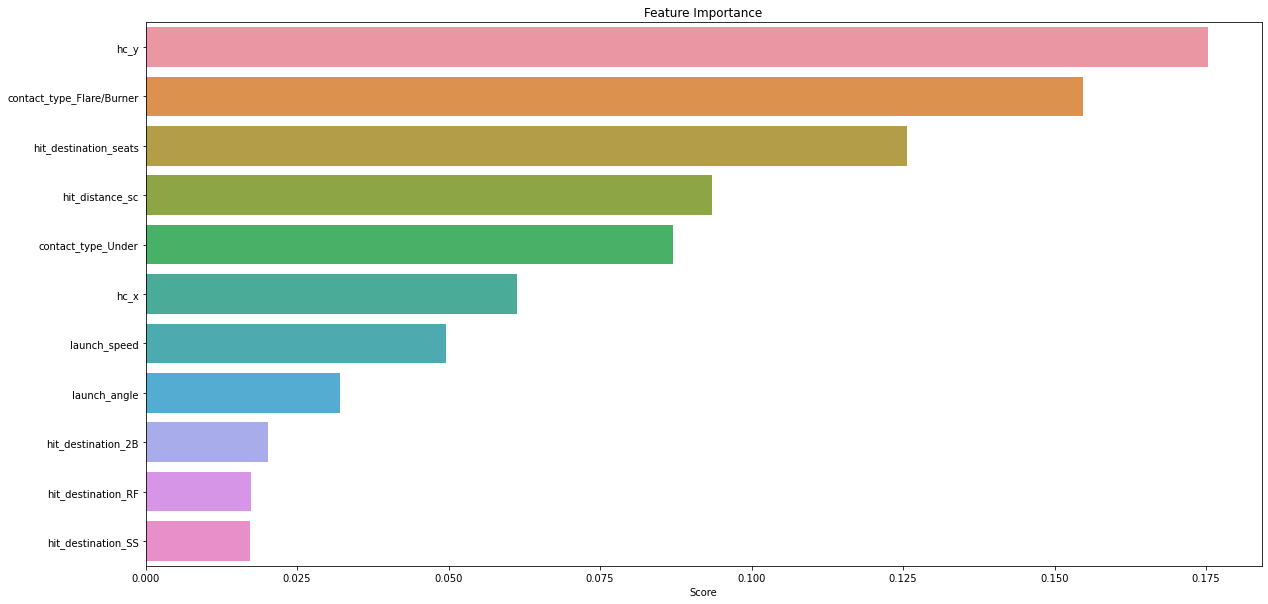

In [56]:
estimator = GradientBoostingClassifier().set_params(**all_params_dict['Optimal GB'])
estimator.fit(X_train, y_train)
fig = plt.figure(figsize=(20, 10))
importance = pd.Series(estimator.feature_importances_, index=wrigley_2022_dummy.columns[:-1]).sort_values(ascending=False)
sns.barplot(x=importance[:11], y=importance[:11].index)
plt.title('Feature Importance')
plt.xlabel('Score')
plt.show()

The fact that the gradient boosting machine was the highest performing (non-voting) model permitted an investigation of the most important features. As expected, the type of contact **(contact_type)** and the location where the ball lands **(hc_y)** plays a huge role in determining whether a contacted ball is a hit or an out. Additional commentary on the top 10 variables:
- contact_type: THe quality of contact can vastly dictate the outcome of the batted ball:
    - **Flare/burner** and **Under** contact types yield hits **66.56%** and **8.59%** of the time, respectively
- hc_x and hc_y: The location of where the ball lands often dictates the difficulty of a fielder converting the contacted ball into an out
- hit_distance_sc: This variable behaves similarly to that of the previous coordinate-based variable
- launch angle: This variable determines the trajectory of the ball and as explained earlier determines the trajectory of the ball's aerial path after contact
- hit_destination: This variable indicates which defensive fielder touches the ball first (or whether the ball ends up in the seats for what is almost always a homerun). If an infielder touches the ball first, it is a hit roughly **7.99%** of the time but if an outfielder touches the ball first, that number jumps to roughly **51.17%**. 
- launch speed: The harder a ball is hit, the less margin for error a potential fielder has in terms of reaction time. In conjunction with launch angle, launch speed can be the difference between a double (two-base hit) and a homerun.

The bolded statistics were calculated directly below. Overall, the most import features in the dataset match baseball convention and logic.

Hit probability by contact type:

In [57]:
contact_type_dict = {}
for item in wrigley_2022_trimmedCat['contact_type'].unique():
    contact_type_dict[item] = wrigley_2022_trimmedCat[wrigley_2022_trimmedCat['contact_type'] == item]['outcome']\
    .value_counts(normalize=True)
    
pd.DataFrame(contact_type_dict).sort_values(by='Hit', axis = 1)

Under      Weak    Topped     Solid  Flare/Burner   Barrel
Hit      0.085896  0.121795  0.163862  0.455752      0.665638  0.74359
Non-hit  0.914104  0.878205  0.836138  0.544248      0.334362  0.25641

Hit probability by type of fielder that touches the ball first:

In [58]:
#hit probability if an infielder touches the ball first

infield_hit_chance = wrigley_2022_trimmedCat[(wrigley_2022_trimmedCat['hit_destination'] != 'LF') &
                                             (wrigley_2022_trimmedCat['hit_destination'] != 'CF') &
                                             (wrigley_2022_trimmedCat['hit_destination'] != 'RF') &
                                             (wrigley_2022_trimmedCat['hit_destination'] != 'seats')]['outcome']\
.value_counts(normalize = True)

#hit probability if an outfielder touches the ball first
outfield_hit_chance = wrigley_2022_trimmedCat[(wrigley_2022_trimmedCat['hit_destination'] == 'LF')|
                                             (wrigley_2022_trimmedCat['hit_destination'] == 'CF')|
                                             (wrigley_2022_trimmedCat['hit_destination'] == 'RF')]['outcome']\
.value_counts(normalize = True)

pd.DataFrame(data={'Infielder': infield_hit_chance,
                  'Outfielder': outfield_hit_chance})

Infielder  Outfielder
Hit       0.079937    0.511678
Non-hit   0.920063    0.488322

### Future approaches

- The data for this analysis was taken strictly from the 2022 season. `pybaseball` data with degree of granularity exists as far back as the 2017 season. If more data is inputted into the training sets, better models will be trained for unseen, future data. 
- Baseball has a multi-class problem for outcomes where different types of hits and outs exist. In the future, more classes of outcomes such as foul balls and errors can be included in the future for better distinguishing **non-hits**.
- `sci-kit learn`'s implementation of neural networks is very high-level. An incorporation of TensorFlow/Kera's implementation would likely yield better models due to greater customization although the main issue with neural networks is its **black-box** nature which prevents the user from deriving feature importances.
- The intention of hyperparameter grid search and general optimization techniques is to determine model parameters that would limit overfitting. However, my grid search may have been too conservative, for the sake of computational expense. An expanded grid of parameter values and options would likely lead to more robust models that can outperform their default equivalents. 